In [1]:
import cv2
import os 
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
dataset = "/Users/parthbehl/machine learning/computer_vision/emotion_detection/dataset/train"
classes = ["angry","disgusted","fearful","happy","neutral","sad","surprised"]
img_size = 224

In [3]:
# Function to load and preprocess images
def create_data(): 
    training_data = []
    for category in classes:
        path = os.path.join(dataset, category)
        class_num = classes.index(category)
        for img in os.listdir(path):   
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
    return training_data

In [4]:
#model should not learn the sequence of data, so we had to shuffle the data 
import random
training_data = create_data()
random.shuffle(training_data)
training_data = training_data[:len(training_data)//8]    #as macbook does not contains GPU

In [5]:
# Separate features and labels
X = []
y = []
for features, labels in training_data:
    X.append(features)
    y.append(labels)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, img_size, img_size, 3) # converting to 4D as MobileNet takes 4D input
y = np.array(y)

In [6]:
print(len(training_data)) # Print the length of the reduced dataset
print(X.shape)

3588
(3588, 224, 224, 3)


In [7]:
#normalise the data 
X=X/255.0

In [8]:
y.shape     #data and labels shape must be same to ensure each image is labelled 

(3588,)

In [9]:
# training the model- transfer learning 

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0

# Assuming the weights file is in the current directory
weights_path = '/Users/parthbehl/machine learning/computer_vision/emotion_detection/efficientnetb0_notop.h5'

model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
model.load_weights(weights_path)


In [10]:
from tensorflow.keras import layers

# Add new layers
x = model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Add the final classification layer
final = layers.Dense(7, activation='softmax')(x)

In [11]:
model = keras.Model(inputs=model.input, outputs=final)

# Compile the model

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [12]:
# epochs = 10
# batch_size = 16
# history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# # Save the model
# model.save('emotion_detection_model.h5')

In [13]:
#load the model 
model = keras.models.load_model('emotion_detection_model.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'emotion_detection_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
frame=cv2.imread("happy.jpg")

In [ ]:
#convert images to gray scale 
#for face detection algo we'll use haarcascades 

facecascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

In [ ]:
faces=facecascade.detectMultiScale(gray,scaleFactor=1.05,minNeighbors=5)
print(f"Number of faces detected: {len(faces)}")
for x,y,w,h in faces:
    image_gray=gray[y:y+h, x:x+w]
    image_color=frame[y:y+h, x:x+w]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,0),2)
    faces=facecascade.detectMultiScale(image_gray)
    if len(faces)==0:
        print("face not detected ")
    else:
        for(ex,ey,ew,eh) in faces:
            face_image=image_color[ey: ey+eh,ex:ex+ew]    

Number of faces detected: 1


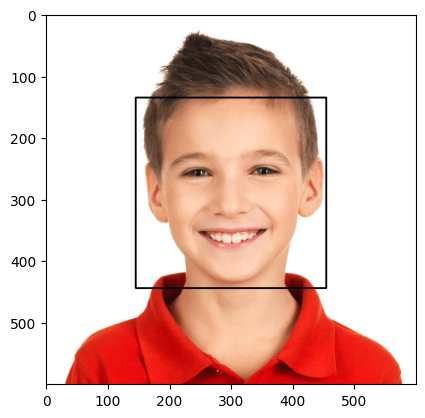

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

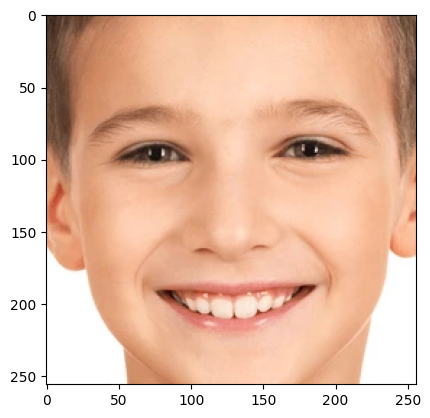

In [ ]:
plt.imshow(cv2.cvtColor(face_image,cv2.COLOR_BGR2RGB))

In [ ]:
final_image=cv2.resize(face_image,(224,224))
final_image=np.expand_dims(final_image,axis=0)   #we need a 4th dimension
final_image=final_image/255.0

In [ ]:
predictions=model.predict(final_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


In [ ]:
np.argmax(predictions)     #angry-0,disgusted-1,fearful-2,happy-3,neutral-4,sad-5,surprised-6

3

In [ ]:
#generate it for live demo image 

import cv2
import numpy as np

path="/Users/parthbehl/machine learning/computer_vision/emotion_detection/dataset/haarcascade_frontalface_default.xml"
cap=cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = facecascade.detectMultiScale(gray, 1.1, 4)
    for x, y, w, h in faces:
        image_gray = gray[y:y+h, x:x+w]
        image_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 0), 2)
        
        # Predict emotion and draw the result
        final_image = cv2.resize(image_color, (224, 224))
        final_image = np.expand_dims(final_image, axis=0)
        final_image = final_image / 255.0
        Predictions = model.predict(final_image)
        status = classes[np.argmax(Predictions)]
        
        # Adjust the position of the text box
        offset_x = x
        offset_y = y - 50 
        font_scale = 3.0 
        font = cv2.FONT_HERSHEY_PLAIN
        (width, height), _ = cv2.getTextSize(status, font, fontScale=font_scale, thickness=3)
        box_coords = ((offset_x, offset_y), (offset_x + width + 2, offset_y - height - 2))
        
        # Draw the emotion status above the face detection box
        cv2.putText(frame, status, (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    if(np.argmax(Predictions)==0):
        status="angry"
        x1,y1, w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 0, 0), cv2.FILLED)
        # Add text
        cv2. putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2. FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
    elif (np.argmax(Predictions)==1):
        status = "disgusted"
        x1,y1, w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 0, 0), cv2.FILLED)
        # Add text
        cv2. putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2. FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
    elif (np.argmax(Predictions)==2):
        status = "fearful"
        x1,y1, w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 0, 0), cv2.FILLED)
        # Add text
        cv2. putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2. FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
    elif (np.argmax(Predictions)==3):
        status = "happy"
        x1,y1, w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 0, 0), cv2.FILLED)
        # Add text
        cv2. putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2. FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        
    elif (np.argmax(Predictions)==4):
        status = "neutral"
        x1,y1, w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 0, 0), cv2.FILLED)
        #Add text
        cv2. putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2. FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        
    elif (np.argmax(Predictions)==5):
        status = "sad"
        x1,y1, w1, h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 0, 0), cv2.FILLED)
        # Add text
        cv2. putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2. FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
    else:
        status = "surprised"
        x1,y1, w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 0, 0), cv2.FILLED)
        # Add text
        cv2. putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2. FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
    cv2.imshow('Face Emotion Detector',frame)
    key = cv2.waitKey(1)
    if key & 0xFF == ord('s'):
        break
cap.release()
cv2.destroyAllWindows()   